# Image preprocessing
predspracovanie obrázkov, môžem použiť tradičné metódy spracovania obrazu

 - do README dať komentár, obrázok, zdrojový kód, po anglicky/slovensky, vysvetliť čo sa stalo prečo som to tak použil

## Morfologické operácie
cieľ 1: vysegmentovať jednotlivé bunky, použijeme operácie na spracovanie obrazu  
cieľ 2: kontúrové analýzy, ale prv binarizovať obrázky, po kontúrových analýzach môžme zisťovať obsahy

 - operácia dilatácie na binárny obrázok
 - opencv - dilatácia, erosion
 - dilatácia - bielie objekty na čiernom pozadí sa mi úmerne zväčšia podľa jadra
 - erózia - opak dilatácie, z bielych plôch binarizovaného obrázku sa mi odfrézuje po okrajoch objektoch, zmenší sa ich plocha
 - opening - kombinácia predchádzajúcich dvoch, objekt zostáva v pôvodnej veľkosti narozdiel od dilatácie a erózie, vo vstupe je záliv, zliate 2 jadierka, s týmto ich oddelíme
 - closing - kombinované, objekt zostáva v pôvodnej veľkosti narozdiel od dilatácie a erózie, ale zálivy/prepojenia zalejeme
 - morfologický gradient - rozdiel medzi základnými operáciami erózie a dilatácie, obrázok erodujem a dilatujem a obrázky spravím rozdiel a dostávam hranový obrázok, môžno použiť na detekciu hrán

## Filtrácia
 - blurovací filter - mean filter, gauss filter, dôležitá veľkosť jadra
 - kombinácia jednotlivých operácií, ktorá privedie k priostreniu hrán - vyrobím si jemný hranový obrázok a ten aditívne/subtratívne pripočítam/odpočítam k pôvodnému a priostrým hrany
 - canny edge detection - algoritmus, nie je to jednoduchý filter, je to postupnosť jednotlivých krokov, ktorá vedie k tomu, že v obraze sa vyhľadávajú hrany a tie sa bianrizujú, výstupom sú už kontúry, nie len jednoduchý hranový obrázok, podľa thresholdu je buď viac alebo menej zachytených hrán
 - bilaterárny filter - implementované v opencv, veľmi pomalý, na velkých obrázkoch to nie je v milisekundách, musíme počkať

In [79]:
import cv2
from typing import Any, Tuple
from matplotlib import pyplot as plt

print(cv2.__version__)

4.7.0


## 1. Load image
Define functions:

In [3]:
def show_img(img: cv2.Mat, txt: str) -> None:
    """
    Show images
    :param: img - image
    :param: txt - text of a window
    """
    cv2.imshow(txt, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def resize_img(img: cv2.Mat, scale_percent: int) -> cv2.Mat:
    """
    Resizing images.
    :param: img - image
    :param: scale_percent - percent by which the image is resized
    :return: Resized image
    """
    # calculate the scale percent of original dimensions
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)

    # dsize
    dsize = (width, height)

    img_resize = cv2.resize(img, dsize)
    return img_resize


načítanie obrázkov:

In [4]:
img1 = cv2.imread('/home/erik/FIIT/2_Ing/2_semester/PVID/cvicenia/figures/TCGA-18-5592-01Z-00-DX1.tif')
img2 = cv2.imread('/home/erik/FIIT/2_Ing/2_semester/PVID/cvicenia/figures/TCGA-21-5784-01Z-00-DX1.tif')
img3 = cv2.imread('/home/erik/FIIT/2_Ing/2_semester/PVID/cvicenia/figures/TCGA-21-5786-01Z-00-DX1.tif')

show_img(img1, 'image')
show_img(img2, 'image')
show_img(img3, 'image')

Qt: Session management error: None of the authentication protocols specified are supported


In [5]:
img1_resize = resize_img(img1, 50) 
img2_resize = resize_img(img2, 50) 
img3_resize = resize_img(img3, 50) 
show_img(img1_resize, 'image')
show_img(img2_resize, 'image')
show_img(img3_resize, 'image')

<Figure size 640x480 with 0 Axes>

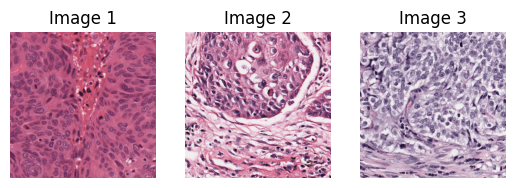

In [6]:
plt.figure()
f, axarr = plt.subplots(1,3)

img1_rgb = cv2.cvtColor(img1_resize, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2_resize, cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(img3_resize, cv2.COLOR_BGR2RGB)

axarr[0].imshow(img1_rgb, cmap = 'gray')
axarr[1].imshow(img2_rgb, cmap = 'gray')
axarr[2].imshow(img3_rgb, cmap = 'gray')

axarr[0].set_title('Image 1')
axarr[1].set_title('Image 2')
axarr[2].set_title('Image 3')

axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')

plt.show()

In [7]:
img1_grayscale = cv2.cvtColor(img1_resize, cv2.COLOR_BGR2GRAY)
img2_grayscale = cv2.cvtColor(img2_resize, cv2.COLOR_BGR2GRAY)
img3_grayscale = cv2.cvtColor(img3_resize, cv2.COLOR_BGR2GRAY)

show_img(img1_grayscale, 'image')
show_img(img2_grayscale, 'image')
show_img(img3_grayscale, 'image')

<Figure size 640x480 with 0 Axes>

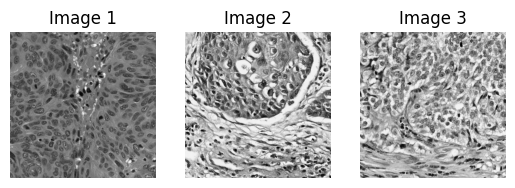

In [8]:
plt.figure()
f, axarr = plt.subplots(1,3)

axarr[0].imshow(img1_grayscale, cmap = 'gray')
axarr[1].imshow(img2_grayscale, cmap = 'gray')
axarr[2].imshow(img3_grayscale, cmap = 'gray')

axarr[0].set_title('Image 1')
axarr[1].set_title('Image 2')
axarr[2].set_title('Image 3')

axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')

plt.show()

## 2. Image pre-processing
Resampling
 - môžem aj výrezy spraviť, patche

In [9]:
# vyššie presunuté

Noise removal - odstránenie šumu blurovaním obrázka  
Averaging - blur filter

In [33]:
img1_blur = cv2.blur(img1_grayscale, (5,5))
show_img(img1_blur, 'image')

img2_blur = cv2.blur(img2_grayscale, (5,5))
show_img(img2_blur, 'image')

img3_blur = cv2.blur(img3_grayscale, (5,5))
show_img(img3_blur, 'image')

Gaussian Blurring

In [36]:
img1_gauss = cv2.GaussianBlur(img1_grayscale, (5,5), 0)
show_img(img1_gauss, 'image')

img2_gauss = cv2.GaussianBlur(img2_grayscale, (5,5), 0)
show_img(img2_gauss, 'image')

img3_gauss = cv2.GaussianBlur(img3_grayscale, (5,5), 0)
show_img(img3_gauss, 'image')

Median Blurring

In [37]:
img1_median = cv2.medianBlur(img1_grayscale, 5)
show_img(img1_median, 'image')

img2_median = cv2.medianBlur(img2_grayscale, 5)
show_img(img2_median, 'image')

img3_median = cv2.medianBlur(img3_grayscale, 5)
show_img(img3_median, 'image')

Bilateral Filtering

In [38]:
img1_bilateral = cv2.bilateralFilter(img1_grayscale, 9, 75, 75)
show_img(img1_bilateral, 'image')

img2_bilateral = cv2.bilateralFilter(img2_grayscale, 9, 75, 75)
show_img(img2_bilateral, 'image')

img3_bilateral = cv2.bilateralFilter(img3_grayscale, 9, 75, 75)
show_img(img3_bilateral, 'image')

<Figure size 640x480 with 0 Axes>

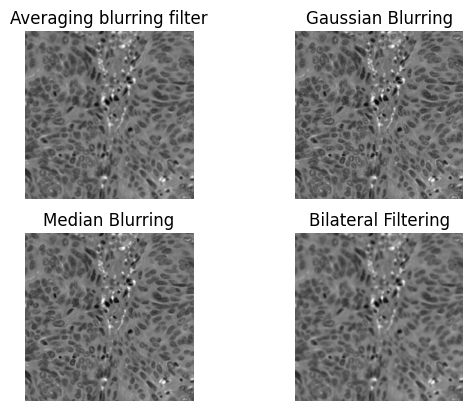

In [49]:
plt.figure()
f, axarr = plt.subplots(2,2)

axarr[0][0].imshow(img1_blur, cmap = 'gray')
axarr[0][1].imshow(img1_gauss, cmap = 'gray')
axarr[1][0].imshow(img1_median, cmap = 'gray')
axarr[1][1].imshow(img1_bilateral, cmap = 'gray')


axarr[0][0].set_title('Averaging blurring filter')
axarr[0][1].set_title('Gaussian Blurring')
axarr[1][0].set_title('Median Blurring')
axarr[1][1].set_title('Bilateral Filtering')

axarr[0][0].axis('off')
axarr[0][1].axis('off')
axarr[1][0].axis('off')
axarr[1][1].axis('off')

plt.show()

<Figure size 640x480 with 0 Axes>

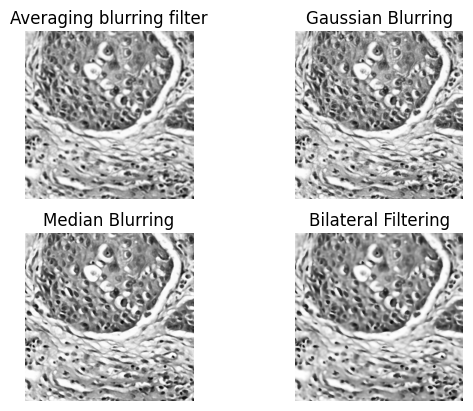

In [50]:
plt.figure()
f, axarr = plt.subplots(2,2)

axarr[0][0].imshow(img2_blur, cmap = 'gray')
axarr[0][1].imshow(img2_gauss, cmap = 'gray')
axarr[1][0].imshow(img2_median, cmap = 'gray')
axarr[1][1].imshow(img2_bilateral, cmap = 'gray')


axarr[0][0].set_title('Averaging blurring filter')
axarr[0][1].set_title('Gaussian Blurring')
axarr[1][0].set_title('Median Blurring')
axarr[1][1].set_title('Bilateral Filtering')

axarr[0][0].axis('off')
axarr[0][1].axis('off')
axarr[1][0].axis('off')
axarr[1][1].axis('off')

plt.show()

<Figure size 640x480 with 0 Axes>

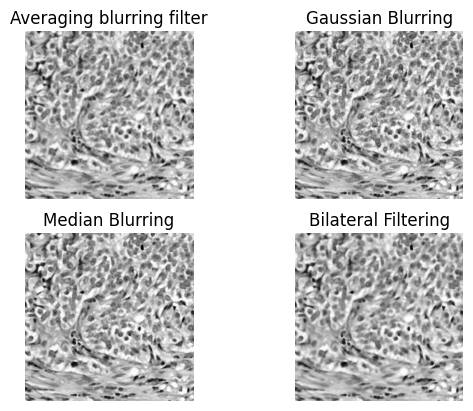

In [51]:
plt.figure()
f, axarr = plt.subplots(2,2)

axarr[0][0].imshow(img3_blur, cmap = 'gray')
axarr[0][1].imshow(img3_gauss, cmap = 'gray')
axarr[1][0].imshow(img3_median, cmap = 'gray')
axarr[1][1].imshow(img3_bilateral, cmap = 'gray')


axarr[0][0].set_title('Averaging blurring filter')
axarr[0][1].set_title('Gaussian Blurring')
axarr[1][0].set_title('Median Blurring')
axarr[1][1].set_title('Bilateral Filtering')

axarr[0][0].axis('off')
axarr[0][1].axis('off')
axarr[1][0].axis('off')
axarr[1][1].axis('off')

plt.show()

Sharpening  
You may try image sharpening according to lectures by using cv::Laplace or cv::blur

## 3. Binarization
Thresholding  
cv::threshold - simple binary threshold

In [52]:
retValue, img1_threshold = cv2.threshold(img1_gauss, 127, 255, cv2.THRESH_BINARY)
show_img(img1_threshold, 'threshold')

retValue, img2_threshold = cv2.threshold(img2_bilateral, 127, 255, cv2.THRESH_BINARY)
show_img(img2_threshold, 'threshold')

retValue, img3_threshold = cv2.threshold(img3_median, 127, 255, cv2.THRESH_BINARY)
show_img(img3_threshold, 'threshold')

OTSU

In [53]:
retValue, img1_otsu = cv2.threshold(img1_gauss, 0, 255, cv2.THRESH_OTSU)
show_img(img1_otsu, 'threshold')

retValue, img2_otsu = cv2.threshold(img2_bilateral, 0, 255, cv2.THRESH_OTSU)
show_img(img2_otsu, 'threshold')

retValue, img3_otsu = cv2.threshold(img3_median, 0, 255, cv2.THRESH_OTSU)
show_img(img3_otsu, 'threshold')

cv::adaptiveThreshold - adaptive method using threshold computed from local area

In [54]:
img1_adaptiveThreshold = cv2.adaptiveThreshold(img1_gauss, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 0)
show_img(img1_adaptiveThreshold, 'threshold')

img2_adaptiveThreshold = cv2.adaptiveThreshold(img2_bilateral, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 0)
show_img(img2_adaptiveThreshold, 'threshold')

img3_adaptiveThreshold = cv2.adaptiveThreshold(img3_median, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 0)
show_img(img3_adaptiveThreshold, 'threshold')

cv::inrange - range based binarization method

In [55]:
img1_inrange = cv2.inRange(img1_gauss, 127, 255)
show_img(img1_inrange, 'threshold')

img2_inrange = cv2.inRange(img2_bilateral, 127, 255)
show_img(img2_inrange, 'threshold')

img3_inrange = cv2.inRange(img3_median, 127, 255)
show_img(img3_inrange, 'threshold')

<Figure size 640x480 with 0 Axes>

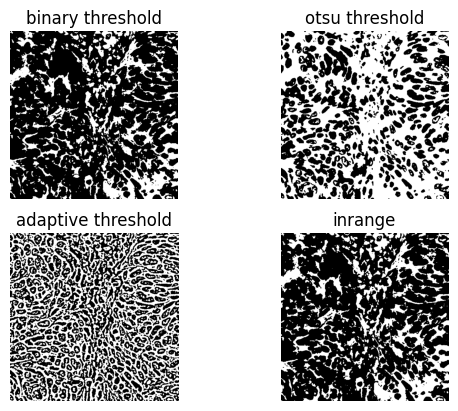

In [19]:
plt.figure()
f, axarr = plt.subplots(2,2)

axarr[0][0].imshow(img1_threshold, cmap = 'gray')
axarr[0][1].imshow(img1_otsu, cmap = 'gray')
axarr[1][0].imshow(img1_adaptiveThreshold, cmap = 'gray')
axarr[1][1].imshow(img1_inrange, cmap = 'gray')


axarr[0][0].set_title('binary threshold')
axarr[0][1].set_title('otsu threshold')
axarr[1][0].set_title('adaptive threshold')
axarr[1][1].set_title('inrange')

axarr[0][0].axis('off')
axarr[0][1].axis('off')
axarr[1][0].axis('off')
axarr[1][1].axis('off')

plt.show()

<Figure size 640x480 with 0 Axes>

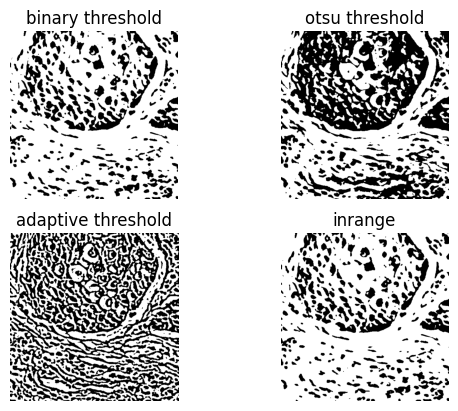

In [47]:
plt.figure()
f, axarr = plt.subplots(2,2)

axarr[0][0].imshow(img2_threshold, cmap = 'gray')
axarr[0][1].imshow(img2_otsu, cmap = 'gray')
axarr[1][0].imshow(img2_adaptiveThreshold, cmap = 'gray')
axarr[1][1].imshow(img2_inrange, cmap = 'gray')


axarr[0][0].set_title('binary threshold')
axarr[0][1].set_title('otsu threshold')
axarr[1][0].set_title('adaptive threshold')
axarr[1][1].set_title('inrange')

axarr[0][0].axis('off')
axarr[0][1].axis('off')
axarr[1][0].axis('off')
axarr[1][1].axis('off')

plt.show()

<Figure size 640x480 with 0 Axes>

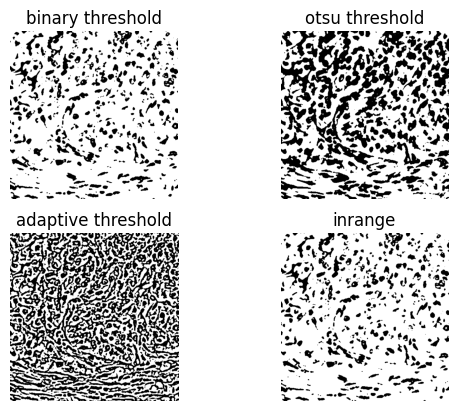

In [56]:
plt.figure()
f, axarr = plt.subplots(2,2)

axarr[0][0].imshow(img3_threshold, cmap = 'gray')
axarr[0][1].imshow(img3_otsu, cmap = 'gray')
axarr[1][0].imshow(img3_adaptiveThreshold, cmap = 'gray')
axarr[1][1].imshow(img3_inrange, cmap = 'gray')


axarr[0][0].set_title('binary threshold')
axarr[0][1].set_title('otsu threshold')
axarr[1][0].set_title('adaptive threshold')
axarr[1][1].set_title('inrange')

axarr[0][0].axis('off')
axarr[0][1].axis('off')
axarr[1][0].axis('off')
axarr[1][1].axis('off')

plt.show()

Edge filter  
cv::Sobel, cv::Laplace - edge filters  

sobel - input 8 bitový obrázok, sobel aj záporne aj kladné číslo, potreba nejaký short integer, pri vizualizácií si rozmyslieť, či chceme mať celý rozsah 0 šedú alebo spraviť absolútnu hodnotu, ide ptm všetko do bieleho, je to viac ako 8 bitov

In [57]:
img1_sobel = cv2.Sobel(src=img1_gauss, ddepth=-1, dx=0, dy=1, ksize=7)
grad_x = cv2.Sobel(src=img1_gauss, ddepth=-1, dx=1, dy=0, ksize=3)
grad_y = cv2.Sobel(src=img1_gauss, ddepth=-1, dx=0, dy=1, ksize=3)

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
show_img(grad, 'sobel')

# img2
img2_grad_x = cv2.Sobel(src=img2_bilateral, ddepth=-1, dx=1, dy=0, ksize=3)
img2_grad_y = cv2.Sobel(src=img2_bilateral, ddepth=-1, dx=0, dy=1, ksize=3)

img2_abs_grad_x = cv2.convertScaleAbs(img2_grad_x)
img2_abs_grad_y = cv2.convertScaleAbs(img2_grad_y)

img2_grad = cv2.addWeighted(img2_abs_grad_x, 0.5, img2_abs_grad_y, 0.5, 0)
show_img(img2_grad, 'sobel')

# img3
img3_grad_x = cv2.Sobel(src=img3_median, ddepth=-1, dx=1, dy=0, ksize=3)
img3_grad_y = cv2.Sobel(src=img3_median, ddepth=-1, dx=0, dy=1, ksize=3)

img3_abs_grad_x = cv2.convertScaleAbs(img3_grad_x)
img3_abs_grad_y = cv2.convertScaleAbs(img3_grad_y)

img3_grad = cv2.addWeighted(img3_abs_grad_x, 0.5, img3_abs_grad_y, 0.5, 0)
show_img(img3_grad, 'sobel')

In [58]:
img1_laplac = cv2.Laplacian(src=img1_gauss, ddepth=-1, ksize=7)
show_img(img1_laplac, 'laplac')

img2_laplac = cv2.Laplacian(src=img2_bilateral, ddepth=-1, ksize=7)
show_img(img2_laplac, 'laplac')

img3_laplac = cv2.Laplacian(src=img3_median, ddepth=-1, ksize=7)
show_img(img3_laplac, 'laplac')

cv::Canny - full edge detection algorithm

In [60]:
img1_canny = cv2.Canny(img1_gauss, 30, 100)
show_img(img1_canny, 'img')

img2_canny = cv2.Canny(img2_bilateral, 30, 100)
show_img(img2_canny, 'img')

img3_canny = cv2.Canny(img3_median, 30, 100)
show_img(img3_canny, 'img')

<Figure size 640x480 with 0 Axes>

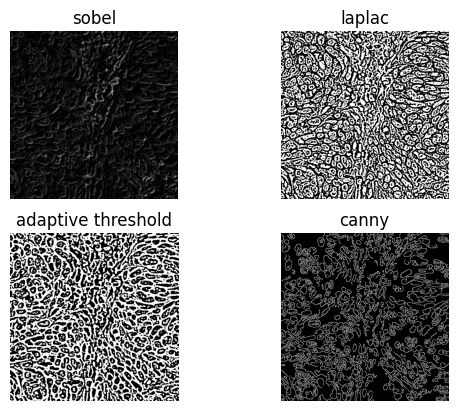

In [23]:
plt.figure()
f, axarr = plt.subplots(2,2)

axarr[0][0].imshow(grad, cmap = 'gray')
axarr[0][1].imshow(img1_laplac, cmap = 'gray')
axarr[1][0].imshow(img1_adaptiveThreshold, cmap = 'gray')
axarr[1][1].imshow(img1_canny, cmap = 'gray')


axarr[0][0].set_title('sobel')
axarr[0][1].set_title('laplac')
axarr[1][0].set_title('adaptive threshold')
axarr[1][1].set_title('canny')

axarr[0][0].axis('off')
axarr[0][1].axis('off')
axarr[1][0].axis('off')
axarr[1][1].axis('off')

plt.show()

<Figure size 640x480 with 0 Axes>

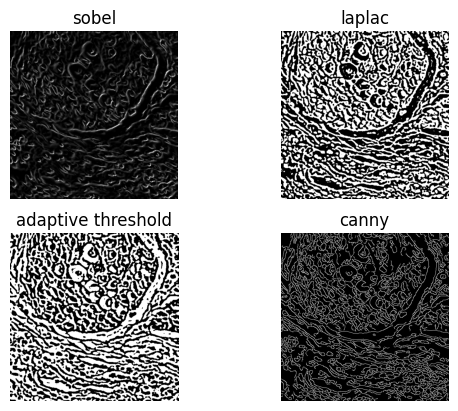

In [61]:
plt.figure()
f, axarr = plt.subplots(2,2)

axarr[0][0].imshow(img2_grad, cmap = 'gray')
axarr[0][1].imshow(img2_laplac, cmap = 'gray')
axarr[1][0].imshow(img2_adaptiveThreshold, cmap = 'gray')
axarr[1][1].imshow(img2_canny, cmap = 'gray')


axarr[0][0].set_title('sobel')
axarr[0][1].set_title('laplac')
axarr[1][0].set_title('adaptive threshold')
axarr[1][1].set_title('canny')

axarr[0][0].axis('off')
axarr[0][1].axis('off')
axarr[1][0].axis('off')
axarr[1][1].axis('off')

plt.show()

<Figure size 640x480 with 0 Axes>

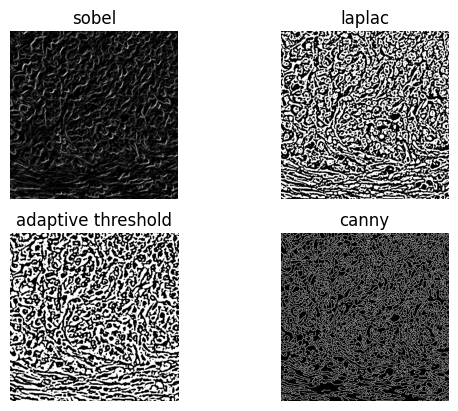

In [63]:
plt.figure()
f, axarr = plt.subplots(2,2)

axarr[0][0].imshow(img3_grad, cmap = 'gray')
axarr[0][1].imshow(img3_laplac, cmap = 'gray')
axarr[1][0].imshow(img3_adaptiveThreshold, cmap = 'gray')
axarr[1][1].imshow(img3_canny, cmap = 'gray')

axarr[0][0].set_title('sobel')
axarr[0][1].set_title('laplac')
axarr[1][0].set_title('adaptive threshold')
axarr[1][1].set_title('canny')

axarr[0][0].axis('off')
axarr[0][1].axis('off')
axarr[1][0].axis('off')
axarr[1][1].axis('off')

plt.show()

## 4. Cell segmentation
Morphological operations

    cv::dilate, cv::erode

In [64]:
img1_dilate = cv2.dilate(img1_canny,(-1, -1), 3)
show_img(img1_dilate, 'img1_dilate')

img2_dilate = cv2.dilate(img2_adaptiveThreshold,(-1, -1), 3)
show_img(img2_dilate, 'img1_dilate')

img3_dilate = cv2.dilate(img3_laplac,(-1, -1), 3)
show_img(img3_dilate, 'img1_dilate')

In [68]:
img1_erode	= cv2.erode(img1_canny, kernel=(3,3))
show_img(img1_erode, 'img1_erode')

img2_erode	= cv2.erode(img2_adaptiveThreshold, kernel=(3,3))
show_img(img2_erode, 'img1_erode')

img3_erode	= cv2.erode(img3_laplac, kernel=(3,3))
show_img(img3_erode, 'img1_erode')

Distance transform

    cv::distanceTransform

In [70]:
img1_distanceTransform = cv2.distanceTransform(src=img1_canny, distanceType=cv2.DIST_L2, maskSize=5)
show_img(img1_distanceTransform, 'img1_distanceTransform')

img2_distanceTransform = cv2.distanceTransform(src=img2_adaptiveThreshold, distanceType=cv2.DIST_L2, maskSize=5)
show_img(img2_distanceTransform, 'img1_distanceTransform')

img3_distanceTransform = cv2.distanceTransform(src=img3_laplac, distanceType=cv2.DIST_L2, maskSize=5)
show_img(img3_distanceTransform, 'img1_distanceTransform')

<Figure size 640x480 with 0 Axes>

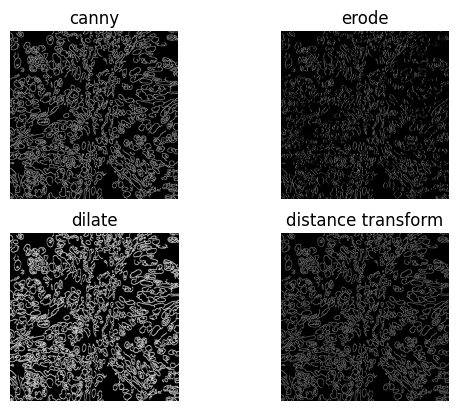

In [27]:
plt.figure()
f, axarr = plt.subplots(2,2)

axarr[0][0].imshow(img1_canny, cmap = 'gray')
axarr[0][1].imshow(img1_erode, cmap = 'gray')
axarr[1][0].imshow(img1_dilate, cmap = 'gray')
axarr[1][1].imshow(img1_distanceTransform, cmap = 'gray')

axarr[0][0].set_title('canny')
axarr[0][1].set_title('erode')
axarr[1][0].set_title('dilate')
axarr[1][1].set_title('distance transform')

axarr[0][0].axis('off')
axarr[0][1].axis('off')
axarr[1][0].axis('off')
axarr[1][1].axis('off')

plt.show()

<Figure size 640x480 with 0 Axes>

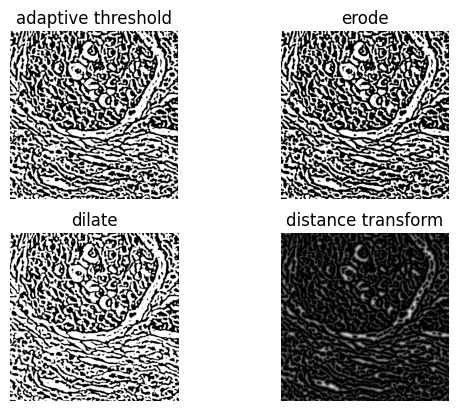

In [72]:
plt.figure()
f, axarr = plt.subplots(2,2)

axarr[0][0].imshow(img2_adaptiveThreshold, cmap = 'gray')
axarr[0][1].imshow(img2_erode, cmap = 'gray')
axarr[1][0].imshow(img2_dilate, cmap = 'gray')
axarr[1][1].imshow(img2_distanceTransform, cmap = 'gray')

axarr[0][0].set_title('adaptive threshold')
axarr[0][1].set_title('erode')
axarr[1][0].set_title('dilate')
axarr[1][1].set_title('distance transform')

axarr[0][0].axis('off')
axarr[0][1].axis('off')
axarr[1][0].axis('off')
axarr[1][1].axis('off')

plt.show()

<Figure size 640x480 with 0 Axes>

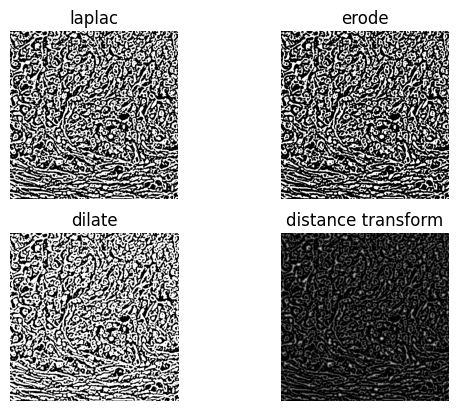

In [73]:
plt.figure()
f, axarr = plt.subplots(2,2)

axarr[0][0].imshow(img3_laplac, cmap = 'gray')
axarr[0][1].imshow(img3_erode, cmap = 'gray')
axarr[1][0].imshow(img3_dilate, cmap = 'gray')
axarr[1][1].imshow(img3_distanceTransform, cmap = 'gray')

axarr[0][0].set_title('laplac')
axarr[0][1].set_title('erode')
axarr[1][0].set_title('dilate')
axarr[1][1].set_title('distance transform')

axarr[0][0].axis('off')
axarr[0][1].axis('off')
axarr[1][0].axis('off')
axarr[1][1].axis('off')

plt.show()

Contours analysis

    cv::findContours - extracts contours from binary image

    cv::drawContours - draws contours

    contour filtering useful functions - cv::area, cv::boundingRect

In [82]:
def contours(img: cv2.Mat, img_input: cv2.Mat, mode: Any, method: int) -> Tuple[cv2.Mat, int]:
    """
    Countour analysis
    :param: img - original image
    :param: img_input - image after morphological operation
    :param: mode - mode in cv2.findContours
    :param: method - method in cv2.findContours
    :returns: tuple of resulting image and number of cells
    """
    img_result = img.copy()
    img_contours, img_hierarchy = cv2.findContours(img_input, mode, method)
    cell_count = 0

    for i in range(0, len(img_contours)):
        if cv2.contourArea(img_contours[i]) > 10:
            cell_count += 1
            cv2.drawContours(img_result, img_contours, i, (0, 255, 0), 4)
        i += 1
    return img_result, cell_count

In [86]:
img1_result, cellIndex_img1 = contours(img1_resize, img1_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
show_img(img1_result, 'img1')
print("count:", cellIndex_img1)

img2_result, cellIndex_img2 = contours(img2_resize, img2_erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
show_img(img2_result, 'img2')
print("count:", cellIndex_img2)

img2_result_dilate, cellIndex_img2_dilate = contours(img2_resize, img2_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
show_img(img2_result_dilate, 'img2')
print("count:", cellIndex_img2_dilate)

img3_result, cellIndex_img3 = contours(img3_resize, img3_erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
show_img(img3_result, 'img3')
print("count:", cellIndex_img3)

count: 271
count: 129
count: 82
count: 290


In [90]:
def show_cells(img: cv2.Mat, img_result: cv2.Mat, cells: int) -> None:
    """
    Show original image and segmentated cells.
    :param: img - original image
    :param: img_result - segmentated image
    :param: cells - number of cells in image
    """
    plt.figure()
    f, axarr = plt.subplots(1,2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_result_rgb = cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)

    axarr[0].imshow(img_rgb)
    axarr[1].imshow(img_result_rgb)

    axarr[0].set_title('Original image')
    axarr[1].set_title(f'Cell segmentation - {cells} cells')

    axarr[0].axis('off')
    axarr[1].axis('off')

    plt.show()

<Figure size 640x480 with 0 Axes>

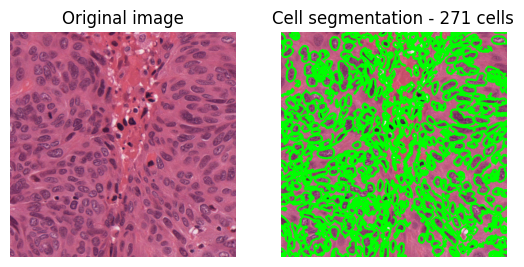

In [91]:
show_cells(img1_resize, img1_result, cellIndex_img1)

<Figure size 640x480 with 0 Axes>

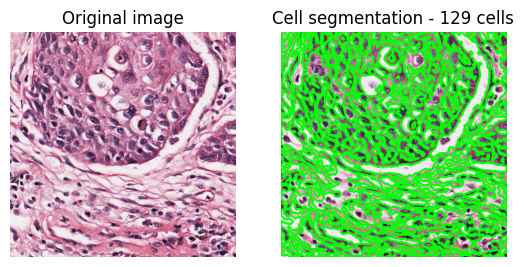

In [92]:
show_cells(img2_resize, img2_result, cellIndex_img2)

<Figure size 640x480 with 0 Axes>

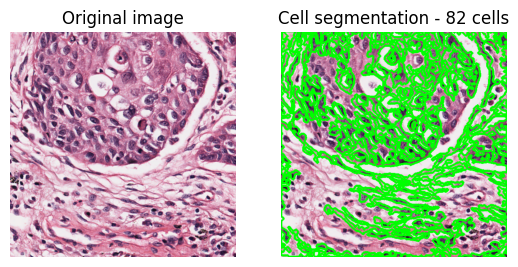

In [93]:
show_cells(img2_resize, img2_result_dilate, cellIndex_img2_dilate)

<Figure size 640x480 with 0 Axes>

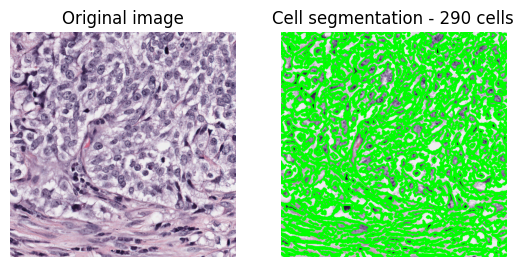

In [94]:
show_cells(img3_resize, img3_result, cellIndex_img3)